In [1]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patheffects as pe

import os
import re
from copy import deepcopy
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import cmcrameri 

# %matplotlib widget
%config InlineBackend.figure_format = 'retina'

In [2]:
# Zeng pure silicate
zeng_sil = [ [0.0094, 0.2533], [0.0133, 0.2831], [0.0188, 0.3167], [0.0263, 0.3533], [0.0363, 0.3926], [0.0502, 0.436], [0.0668, 0.4778], [0.0883, 0.5214], [0.1151, 0.5659], [0.1453, 0.6064], [0.1882, 0.6542], [0.2467, 0.7083], [0.3252, 0.7682], [0.4289, 0.8332], [0.5643, 0.9031], [0.7393, 0.9772], [0.9634, 1.0552], [1.2479, 1.1368], [1.6061, 1.2214], [2.0541, 1.3089], [2.6105, 1.3987], [3.2973, 1.4906], [4.1404, 1.5844], [5.1702, 1.6797], [6.4220, 1.7763], [7.9376, 1.8739], [9.7656, 1.9725], [11.9628, 2.0718], [14.5957, 2.1716], [17.7419, 2.2719], [21.4589, 2.3716], [25.6899, 2.4665], [30.5051, 2.5564], [35.9972, 2.6420], [42.2655, 2.7237], [49.4164, 2.8016], [57.5637, 2.8759], [66.8285, 2.9467], [77.339, 3.0138], [89.2314, 3.0774], [102.6513, 3.1372], [117.7562, 3.1933], [134.7189, 3.2455], [153.7329, 3.2941], [175.0178, 3.3389], [198.8262, 3.3801], [225.4501, 3.4179], [255.2280, 3.4524], [288.5492, 3.484], [325.8570, 3.5128], [367.6497, 3.539], [414.4773, 3.5629], [466.9373, 3.5847], [525.6648, 3.6044], [591.3243, 3.6222], [664.5985, 3.6379] ]
zeng_sil = np.array(zeng_sil).T

# Zeng Earth like (32.5% Fe + silicate)
zeng_mix = [ [0.003, 0.1648], [0.0042, 0.1831], [0.0059, 0.2036], [0.0082, 0.2267], [0.0114, 0.2524], [0.0159, 0.281], [0.0221, 0.3128], [0.0306, 0.3476], [0.042, 0.3854], [0.0575, 0.4265], [0.0779, 0.4697], [0.1046, 0.515], [0.1393, 0.5625], [0.1831, 0.61], [0.2402, 0.6608], [0.3142, 0.7150], [0.4093, 0.7725], [0.5304, 0.8330], [0.6835, 0.8964], [0.8756, 0.9625], [1.115, 1.0309], [1.4114, 1.1015], [1.7763, 1.1741], [2.2233, 1.2485], [2.7682, 1.3245], [3.4297, 1.4019], [4.2296, 1.4806], [5.1932, 1.5604], [6.3505, 1.6412], [7.7363, 1.7228], [9.3912, 1.8052], [11.3628, 1.8883], [13.7066, 1.9719], [16.4870, 2.0559], [19.7797, 2.1404], [23.6585, 2.2246], [28.152, 2.3063], [33.3138, 2.3848], [39.2487, 2.4602], [46.0693, 2.5325], [53.8965, 2.6019], [62.8692, 2.6683], [73.1339, 2.7319], [84.8337, 2.7924], [98.1197, 2.8497], [113.1545, 2.9034], [130.1162, 2.9536], [149.2054, 3.0002], [170.6534, 3.0431]]
zeng_mix = np.array(zeng_mix).T

In [3]:
M_earth = 5.972e24
R_earth = 6.371e6

In [4]:
# Directory containing the data files
output_dir = "../../output_files/"

# Regex to extract M and C from filenames
pattern = re.compile(r"planet_profile_M([\d\.]+)_C([\d\.]+)\.txt")

# Store data [[mass, core, radius], ...]
points = []

for fname in os.listdir(output_dir):
    match = pattern.match(fname)
    if match:
        M = float(match.group(1))
        C = float(match.group(2))

        data = np.loadtxt(output_dir+fname, delimiter=' ').T
        radius = float(data[0][-1])

        points.append([M, C, radius/R_earth])

# These are not sorted
points = np.array(points)
pointsT = points.T
print(np.shape(pointsT))

# Prepare data for plotting
mass_unique = np.unique(pointsT[0])
core_unique = np.unique(pointsT[1])

print(mass_unique)
print(core_unique)

(3, 520)
[ 0.25  0.5   0.75  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.
  3.25  3.5   3.75  4.    4.25  4.5   4.75  5.    5.25  5.5   5.75  6.
  6.25  6.5   6.75  7.    7.25  7.5   7.75  8.    8.25  8.5   8.75  9.
  9.25  9.5   9.75 10.  ]
[0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7 ]


In [30]:
def fit(mc, m0,m1, c0,c1, e0,e1, o1):
    m = mc[0]
    c = mc[1]
    return m0*m**m1 + c0*c**c1 + e0*(m*c)**e1  + o1

popt, pcov = curve_fit(fit, (pointsT[0], pointsT[1]), pointsT[2])
for i,p in enumerate(popt):
    print(f"Parameter {i:d}:  {p:+.5f} (5dp)")

print([float(round(p,10)) for p in popt])

Parameter 0:  +1.20429 (5dp)
Parameter 1:  +0.26367 (5dp)
Parameter 2:  -0.21162 (5dp)
Parameter 3:  +1.99346 (5dp)
Parameter 4:  -0.10302 (5dp)
Parameter 5:  +0.59033 (5dp)
Parameter 6:  -0.15124 (5dp)
[1.204294203, 0.2636659626, -0.2116187596, 1.9934641771, -0.1030231538, 0.5903312114, -0.1512426729]


In [6]:
y_dat = []
y_fit = []
e_fit = []
for m in mass_unique:
    for c in core_unique:
        i = np.argwhere((m == pointsT[0]) & (c == pointsT[1])).flatten()
        if len(i) > 0:
            i = int(i.flatten()[0])
        else:
            continue
        y_dat.append(pointsT[2][i])
        y_fit.append(fit((m,c), *popt))

y_dat = np.array(y_dat)
y_fit = np.array(y_fit)

# Mean absolute percentage error
e_dif = np.abs( (y_dat - y_fit)  / y_dat)
MAPE = np.sum(e_dif) / len(e_dif) * 100
print(f"MAPE: {MAPE:2.6f}%")

# R^2 coefficient of determination
ss_res = np.sum((y_dat - y_fit) ** 2)
ss_tot = np.sum((y_dat - np.mean(y_dat)) ** 2)
R2 = 1 - (ss_res / ss_tot)
print(f"R^2 : {R2:2.6f}")


MAPE: 0.218640%
R^2 : 0.999845


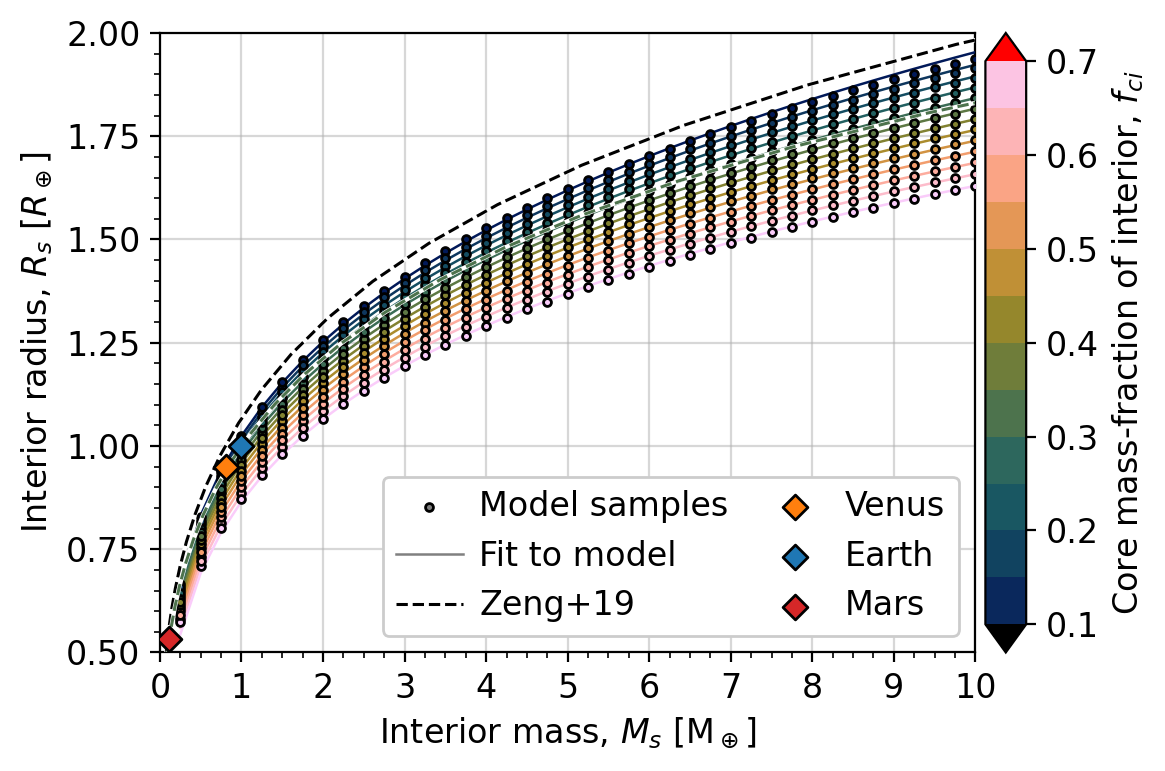

In [13]:

cmin = 0.1
cmax = 0.7

cmap = deepcopy(cmcrameri.cm.batlow)
cmap.set_under('k')
cmap.set_over('r')

norm = mpl.colors.Normalize(vmin=cmin, vmax=cmax)
sm = cm.ScalarMappable(norm=norm, cmap=cmap)

# Plot: for each mass and core fraction, give radius
fig,ax = plt.subplots(figsize=(6,4))

# Model samples
s = 8
ax.scatter([],[], s=s, color='grey', label="Model samples", edgecolors='k')
for p in points:
    x = p[0]
    y = p[2]
    col = sm.to_rgba(p[1])
    ax.scatter(x, y, color=col, zorder=9, edgecolors='k', s=s)

# Show fitted curve 
ax.plot(    [],[],lw=0.9, color='grey', label="Fit to model", ls='solid')
for i,c_tst in enumerate(core_unique):
    m_arr = np.linspace(np.amin(mass_unique), np.amax(mass_unique), 40)
    r_arr = [fit((m,c_tst), *popt) for m in m_arr]
    ax.plot(m_arr,r_arr, color=sm.to_rgba(c_tst), ls='solid', zorder=6, lw=0.9)

# Zeng2019 curves
pez = [pe.Stroke(linewidth=4, foreground='k'), pe.Normal()]
lwz = 1.1
ax.plot(zeng_sil[0], zeng_sil[1], zorder=301, ls='solid',  lw=lwz*1.4, color='w')
ax.plot(zeng_sil[0], zeng_sil[1], zorder=302, ls='dashed', lw=lwz,color=sm.to_rgba(0.0), label="Zeng+19")
ax.plot(zeng_mix[0], zeng_mix[1], zorder=311, ls='solid',  lw=lwz*1.4, color='w')
ax.plot(zeng_mix[0], zeng_mix[1], zorder=312, ls='dashed', lw=lwz, color=sm.to_rgba(0.325))

# Known planets (radius/km, mass/1e24kg)
# https://ssd.jpl.nasa.gov/planets/phys_par.html
planets = {
    # "Mercury": [2439.4, 0.33010, 'grey'],
    "Venus":   [6051.8, 4.86731, 'tab:orange'],
    "Earth":   [6371.0, 5.97217, 'tab:blue'],
    "Mars":    [3389.5, 0.64169, 'tab:red']
}
for p,v in planets.items():
    ax.scatter(v[1]*1e24/M_earth, v[0]*1e3/R_earth, label=p, zorder=900, s=40, marker='D', edgecolors='k', color=v[2])

ax.set_xlabel(r'Interior mass, $M_s$ [M$_\oplus$]')
ax.set_xlim(left=0, right=10)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1.0))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.25))

ax.set_ylabel(r'Interior radius, $R_s$ [$R_\oplus$]')
ax.set_ylim(bottom=0.50, top=2.0)
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.25))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))

ax.legend(framealpha=1, loc='lower right', ncol=2, 
          handletextpad=0.5, columnspacing=1.0)

ax.grid(zorder=-10, alpha=0.5)

cax =  make_axes_locatable(ax).append_axes("right", size="5%",pad=0.05)
bnd = np.arange(cmin,cmax+0.05,0.05)
tck = np.arange(cmin,cmax+0.1,0.1)
cb = fig.colorbar(sm, cax=cax, label=r"Core mass-fraction of interior, $f_{ci}$", 
                  boundaries=bnd, ticks=tck,
                  extend='both')
cb.ax.set_ylim(bottom=cmin, top=cmax)

fig.tight_layout()
plt.show()
fig.savefig(output_dir+"interior.pdf", bbox_inches='tight')